## Build A Basic ChatBot With LangGraph(Graph API)

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages

add_messages is a one reducer which helps to store information in state variable by appending.
It appends in new information in that variable.

In [2]:
class State(TypedDict):
    # Messages have the type "list". The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwritin them)
    messages:Annotated[list,add_messages]



In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
#There are 2 ways to interact with llms 
from langchain_groq import ChatGroq # 1st Way
from langchain.chat_models import init_chat_model  # 2nd Way

llm=ChatGroq(model="llama3-8b-8192")

In [5]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001DF95570CE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001DF956B8290>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001DF956B8950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001DF956B8680>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
# For Every node there is a node defination
def chatbot(state:State):
    return{"messages":[llm.invoke(state["messages"])]} 

In [8]:
graph_builder = StateGraph(State)

#add node
graph_builder.add_node("llmchatbot",chatbot)
#add edge
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)


# compile the Graph
graph=graph_builder.compile()

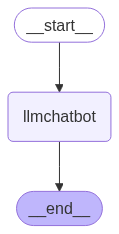

In [9]:
##Visualize the graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
responce=graph.invoke({'messages':"Hi"})

In [11]:
responce["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [12]:
for event in graph.stream({"messages":"Hii how are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi! I'm just an AI, so I don't have feelings like humans do, but I'm here to help you with any questions or topics you'd like to discuss. How about you? How's your day going?


# ChatBot With Tool

In [13]:
from langchain_tavily import TavilySearch

tool= TavilySearch(max_results=2)
tool.invoke("What is Langgraph")

{'query': 'What is Langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling c

In [14]:
# what is doc stream ---- Here the data in triple "" is a doc stream
def multiply(a:int,b:int)->int:
    """
    Multiply a and b

    Args :
        a (int): first int
        b (int): second int
    Returns :
        int: output int
    """
    return a*b

In [15]:
tools = [tool,multiply]

In [16]:
llm_with_tool=llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001DF956B8950>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001DF956B8680>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [18]:
class State(TypedDict):
    # Messages have the type "list". The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwritin them)
    messages:Annotated[list,add_messages]


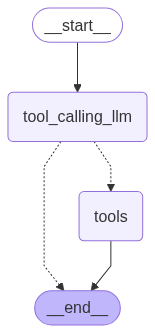

In [19]:
## StateGraph
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Defination 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Add Edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call - > tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call - > tools_condition routes to END
    tools_condition
)

builder.add_edge("tools",END)

## Compile the graph
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png())) 






In [20]:
responce=graph.invoke({"messages":"What is the recent ai news"})

In [21]:
responce['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://aibusiness.com/ml/nvidia-self-driving-software-platform-in-full-production-gtc-paris", "title": "Nvidia Self-Driving Software Platform in Full Production; GTC Paris - AI Business", "score": 0.76194656, "published_date": "Thu, 12 Jun 2025 12:38:26 GMT", "content": "byStu Rubin, Casey Kacirek and Jenn Gerasimov\\n\\nJun 11, 2025\\n\\n2 Min Read\\n\\nGenerative AI\\n\\n#### Related Topics\\n\\n   Foundation Models\\n\\n   Agentic AI\\n\\n#### Recent inGenerative AI\\n\\nSee All\\n\\nGoogle Cloud\'s Daniel RoodImage 15Agentic AI\\n\\nGoogle Takes Agentic Leap: AI Summit London 2025Google Takes Agentic Leap: AI Summit London 2025\\n\\nbyBerenice Baker\\n\\nJun 12, 2025\\n\\n3 Min Read\\n\\nthumbnailImage 16Generative AI [...] Robotic process automation\\n\\n   Intelligent automation\\n\\n#### Recent inAutomation\\n\\nSee All\\n\\nNew York City chief technology officer Matthew

In [22]:
for m in responce['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (b2e6x627n)
 Call ID: b2e6x627n
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://aibusiness.com/ml/nvidia-self-driving-software-platform-in-full-production-gtc-paris", "title": "Nvidia Self-Driving Software Platform in Full Production; GTC Paris - AI Business", "score": 0.76194656, "published_date": "Thu, 12 Jun 2025 12:38:26 GMT", "content": "byStu Rubin, Casey Kacirek and Jenn Gerasimov\n\nJun 11, 2025\n\n2 Min Read\n\nGenerative AI\n\n#### Related Topics\n\n   Foundation Models\n\n   Agentic AI\n\n#### Recent inGenerative AI\n\

In [23]:
responce=graph.invoke({"messages":"What is 2 multiplied by 3 and then multiply by 10"})
for m in responce['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (p8gjn9x07)
 Call ID: p8gjn9x07
  Args:
    a: 2
    b: 3
  multiply (vvphwgt73)
 Call ID: vvphwgt73
  Args:
    a: 6
    b: 10
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: multiply

60


In [24]:
responce=graph.invoke({"messages":"Give me recent ai news and 2 multiplied by 3 and then multipy by 10"})
for m in responce['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me recent ai news and 2 multiplied by 3 and then multipy by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (pj183a3b7)
 Call ID: pj183a3b7
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
  multiply (86prshemp)
 Call ID: 86prshemp
  Args:
    a: 2
    b: 3
  multiply (qp7g2xnbm)
 Call ID: qp7g2xnbm
  Args:
    a: 6
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest AI News, Analysis & Events", "content": "Apple hints at AI integration in chip design process · AI adoption matures but deployment hurdles remain · Ren Zhengfei: China's AI future and Huawei's long", "scor

# ReACT Agent Architecture

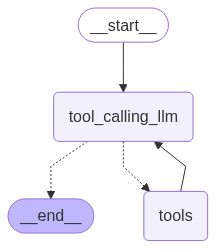

In [25]:
## StateGraph
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Defination 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Add Edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call - > tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call - > tools_condition routes to END
    tools_condition
)
 
builder.add_edge("tools","tool_calling_llm") #change
builder.add_edge("tool_calling_llm",END) # change
## Compile the graph
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png())) 

In [26]:
responce=graph.invoke({"messages" : "Give me the recent ai news and then multiply 5 by 10"})
for m in responce['messages']:
    m.pretty_print()


================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (f79rgjyqv)
 Call ID: f79rgjyqv
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
  multiply (4d03qy0k1)
 Call ID: 4d03qy0k1
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4009603/north-koreas-bluenoroff-uses-ai-deepfakes-to-push-mac-malware-in-fake-zoom-calls.html", "title": "North Korea’s BlueNoroff uses AI deepfakes to push Mac malware in fake Zoom calls - csoonline.com", "score": 0.6615081, "published_date": "Thu, 19 Jun 2025 12:06:34 GMT", "content": "Related content\n-------

# Adding Memory In Agentic Graph

In [27]:
responce=graph.invoke({"messages" : "Heyyy! My Name is Namit"})
for m in responce['messages']:
    m.pretty_print()


================================ Human Message =================================

Heyyy! My Name is Namit
================================== Ai Message ==================================

Nice to meet you, Namit! It's great to have you here. What brings you to this conversation?


In [28]:
responce=graph.invoke({"messages" : "What is My name"})
for m in responce['messages']:
    m.pretty_print()

================================ Human Message =================================

What is My name
================================== Ai Message ==================================
Tool Calls:
  multiply (mm041y9c7)
 Call ID: mm041y9c7
  Args:
    a: 1
    b: 2
================================= Tool Message =================================
Name: multiply

2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (stfdn146s)
 Call ID: stfdn146s
  Args:
    query: What is my name
================================= Tool Message =================================
Name: tavily_search

{"query": "What is my name", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What Does My Name Mean? The Meaning Of Names", "url": "https://www.names.org/", "content": "Names.org is a website that helps you discover the meaning, origin, popularity, and trends of your name. You can search by first name, last name, full name, or 

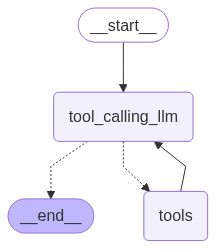

In [57]:
## StateGraph
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver #chnage

memory = MemorySaver() #change

# Node Defination 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Add Edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call - > tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call - > tools_condition routes to END
    tools_condition
)
 
builder.add_edge("tools","tool_calling_llm") #change
builder.add_edge("tool_calling_llm",END) # change
## Compile the graph
graph=builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png())) 

In [71]:
config={"configurable":{'thread_id':"1"}}

responce=graph.invoke({"messages":"My name is Namit"},config=config)
responce

{'messages': [HumanMessage(content='My name is Namit', additional_kwargs={}, response_metadata={}, id='342f318e-5b72-4bc7-b9be-267325ad151e'),
  AIMessage(content="Nice to meet you, Namit! I'm here to help you with your task. Can you please provide the input for the tool usage or the question you'd like me to answer directly?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 2204, 'total_tokens': 2244, 'completion_time': 0.033206563, 'prompt_time': 0.262613489, 'queue_time': 0.05185345000000002, 'total_time': 0.295820052}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--ca964ade-e946-4683-b041-02edf858141c-0', usage_metadata={'input_tokens': 2204, 'output_tokens': 40, 'total_tokens': 2244})]}

In [72]:
responce['messages'][-1].content

"Nice to meet you, Namit! I'm here to help you with your task. Can you please provide the input for the tool usage or the question you'd like me to answer directly?"

In [75]:
responce=graph.invoke({"messages":"tell  My Name"},config=config)

In [76]:
responce['messages'][-1].content

'I think there\'s been a misunderstanding! The tool call id "0q62893vp" doesn\'t seem to be related to the query "My Name". The tool "multiply" is a simple arithmetic operation that multiplies two numbers, and the result is 1.\n\nSince we didn\'t get any useful information about your name, I\'ll try again. Can you please tell me more about what you\'re looking for? Are you looking for information about the meaning or origin of your name, Namit? Or is there something else I can help you with?'

# Streaming

In [77]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [78]:
def superbot(state:State):
    return {'messages':[llm.invoke(state['messages'])]}

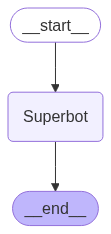

In [79]:
graph=StateGraph(State)

#node 
graph.add_node("Superbot",superbot)

#edge
graph.add_edge(START,"Superbot")
graph.add_edge("Superbot",END)

graph_builder=graph.compile(checkpointer=memory)

## Display
from IPython.display import display , Image
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [81]:
## Invocation 

config={"configurable":{'thread_id':"1"}}

graph_builder.invoke({"messages":"Hii, My name is Namit And I Like Cricket"},config)


{'messages': [HumanMessage(content='Hii, My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='4df65115-4f36-4036-87b5-dc35b84b2f66'),
  AIMessage(content="Hello Namit! Nice to meet you! Cricket is a fantastic sport, isn't it? Do you have a favorite team or player? Have you ever played cricket yourself?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 22, 'total_tokens': 58, 'completion_time': 0.030336747, 'prompt_time': 0.004148945, 'queue_time': 0.047092857, 'total_time': 0.034485692}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--772e68be-a470-4c6c-b940-7d31cfd9d631-0', usage_metadata={'input_tokens': 22, 'output_tokens': 36, 'total_tokens': 58})]}

### Streaming
Methods: . stream() and astream()
- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values**: This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [82]:
## Create a thread 
config={"configurable":{'thread_id':"3"}}

for chunk in graph_builder.stream({'messages':"Hii,My name is Namit And I Like Cricket"},config,stream_mode="updates"):
    print (chunk)


{'Superbot': {'messages': [AIMessage(content="Hi Namit! Nice to meet you! It's great to know that you like cricket! Which team do you support? Or do you have a favorite player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 22, 'total_tokens': 56, 'completion_time': 0.029329128, 'prompt_time': 0.00953888, 'queue_time': 0.34332332, 'total_time': 0.038868008}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--2ebe1610-78cd-476b-bc26-c9219443dd6e-0', usage_metadata={'input_tokens': 22, 'output_tokens': 34, 'total_tokens': 56})]}}


In [83]:
for chunk in graph_builder.stream({'messages':"Hii,My name is Namit And I Like Cricket"},config,stream_mode="values"):
    print (chunk)

{'messages': [HumanMessage(content='Hii,My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='3bb27b87-63ac-47f2-86cf-37a6608ae498'), AIMessage(content="Hi Namit! Nice to meet you! It's great to know that you like cricket! Which team do you support? Or do you have a favorite player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 22, 'total_tokens': 56, 'completion_time': 0.029329128, 'prompt_time': 0.00953888, 'queue_time': 0.34332332, 'total_time': 0.038868008}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--2ebe1610-78cd-476b-bc26-c9219443dd6e-0', usage_metadata={'input_tokens': 22, 'output_tokens': 34, 'total_tokens': 56}), HumanMessage(content='Hii,My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='3d695405-3010-42c7-b4ed-6e10f6a2b417')]}
{'messages': [HumanMessage(content='Hii,My name i

In [84]:
## Create a thread 
config={"configurable":{'thread_id':"4"}}

for chunk in graph_builder.stream({'messages':"Hii,My name is Namit And I Like Cricket"},config,stream_mode="updates"):
    print (chunk)

{'Superbot': {'messages': [AIMessage(content="Nice to meet you, Namit! Cricket is a fantastic sport, isn't it? Do you have a favorite team or player? Are you a die-hard fan of the Indian cricket team or do you support another team?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 22, 'total_tokens': 68, 'completion_time': 0.039960607, 'prompt_time': 0.004734787, 'queue_time': 0.045313105, 'total_time': 0.044695394}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--c95a1ee8-a002-4f21-9a43-0f79fd727448-0', usage_metadata={'input_tokens': 22, 'output_tokens': 46, 'total_tokens': 68})]}}


In [87]:
for chunk in graph_builder.stream({'messages':"I also Like Football"},config,stream_mode="values"):
    print (chunk)

{'messages': [HumanMessage(content='Hii,My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='41157532-5d2d-4748-8056-58cd494217fc'), AIMessage(content="Nice to meet you, Namit! Cricket is a fantastic sport, isn't it? Do you have a favorite team or player? Are you a die-hard fan of the Indian cricket team or do you support another team?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 22, 'total_tokens': 68, 'completion_time': 0.039960607, 'prompt_time': 0.004734787, 'queue_time': 0.045313105, 'total_time': 0.044695394}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--c95a1ee8-a002-4f21-9a43-0f79fd727448-0', usage_metadata={'input_tokens': 22, 'output_tokens': 46, 'total_tokens': 68}), HumanMessage(content='I also Like Football', additional_kwargs={}, response_metadata={}, id='630c8c79-6fba-4dcc-be32-b4de71fcb0d3'), HumanMessage